In [10]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import sys
from pathlib import Path

import pandas as pd

import spacy
from spacy import displacy
from textblob import TextBlob, Word
import nltk
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import train_test_split
# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to /Users/tonghuang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
DATA_DIR = Path("./")
files = (DATA_DIR / 'bbc').glob('**/*.txt')
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        topic = file.parts[-2]
        lines = f.readlines()
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic.capitalize(), heading, body])

In [11]:
docs = pd.DataFrame(doc_list, columns=['Category', 'Heading', 'Article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  2225 non-null   object
 1   Heading   2225 non-null   object
 2   Article   2225 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB


In [12]:
train_docs, test_docs = train_test_split(docs,
                                        stratify= docs.Category,
                                        test_size=50,
                                        random_state=42)

In [15]:
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [16]:
pd.Series(test_docs.Category).value_counts()

Category
Sport            12
Business         11
Entertainment     9
Tech              9
Politics          9
Name: count, dtype: int64

In [18]:
vectorizer = TfidfVectorizer(max_df=0.25,
                            min_df=0.01,
                            stop_words="english",
                            binary=False)
train_dtm = vectorizer.fit_transform(train_docs.Article)
test_dtm = vectorizer.transform(test_docs.Article)

# Get Token count

In [26]:
train_token_count = train_dtm.sum(0).A.squeeze()
tokens = vectorizer.get_feature_names_out()
word_count = pd.Series(train_token_count,
                       index=tokens).sort_values(ascending=False)
word_count.head()

film          41.969806
government    38.831057
uk            36.030715
game          36.018343
best          35.457674
dtype: float64

In [29]:
n_components = 5
topic_labels = ['Topic {}'.format(i) for i in range(1, n_components + 1)]
svd = TruncatedSVD(n_components=n_components, n_iter=5, random_state=42)
svd.fit(train_dtm)
svd.singular_values_

array([8.91758111, 5.72637431, 5.40074482, 5.06770949, 4.73172083])

In [31]:
train_doc_topics = svd.transform(train_dtm)

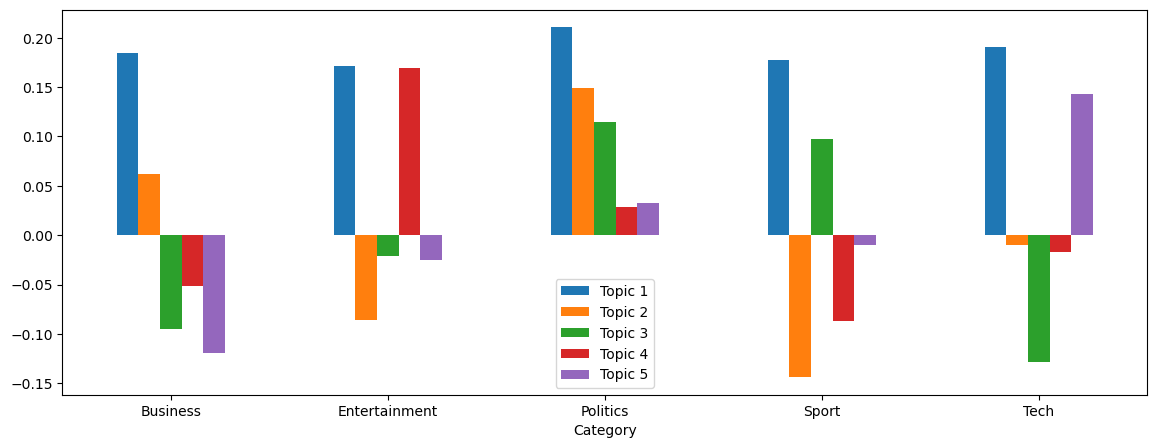

In [37]:
train_result = pd.DataFrame(data=train_doc_topics,
                            columns=topic_labels,
                            index=train_docs.Category)
train_result.groupby(level='Category').mean().plot.bar(figsize=(14, 5), rot=0);

In [38]:
topics = pd.DataFrame(svd.components_.T, index=tokens, columns=topic_labels)
topics.loc[word_count.head(10).index]

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
film,0.098131,-0.158746,-0.041890,0.470003,-0.100410
government,0.105534,0.156803,0.051458,0.000527,-0.033040
uk,0.092203,0.031396,-0.057260,0.038588,0.015374
game,0.090872,-0.165281,0.076286,-0.108514,0.055732
best,0.086469,-0.144365,0.015053,0.261192,-0.088418
labour,0.101441,0.242068,0.229497,0.070853,0.059631
music,0.077332,-0.045554,-0.114794,0.068489,0.138213
000,0.072875,0.029264,-0.045432,0.001696,-0.011724
company,0.067113,0.023057,-0.099327,-0.028270,-0.055466
number,0.069624,-0.038279,-0.022294,0.027328,0.008494
